# Portfolio optimization

## Importing libs

In [1]:
import numpy as np
import pandas as pd

## Importing data

In [2]:
from src.yahoo_data import fetch_data

# TLT: Long bond ETF
# GLD: Gold
# SPY: S&P 500 ETF
# QQQ: Nasdaq ETF
# VWO: Emerging Markets ETF

asset_list = ['TLT','GLD','SPY','QQQ','VWO']

df = fetch_data(asset_list)

TLT
Index(['Date', 'TLT_Close'], dtype='object')
GLD
Index(['Date', 'GLD_Close'], dtype='object')
SPY
Index(['Date', 'SPY_Close'], dtype='object')
QQQ
Index(['Date', 'QQQ_Close'], dtype='object')
VWO
Index(['Date', 'VWO_Close'], dtype='object')


<AxesSubplot:>

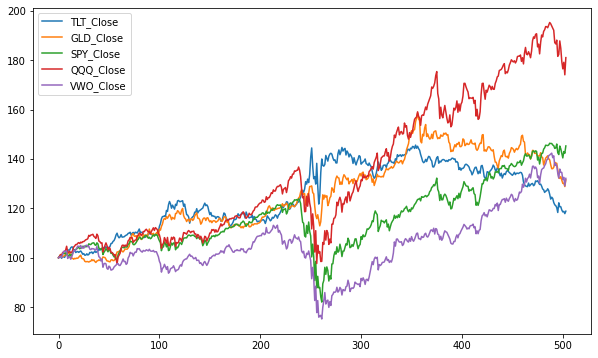

In [3]:
import matplotlib.pyplot as plt

df_without_date = df.copy()
df_without_date.drop(['Date'], inplace=True, axis=1)
(df_without_date/df_without_date.iloc[0]*100).plot(figsize=(10,6))

## Expected returns

In [4]:
num_assets = len(asset_list)

returns = np.log(df_without_date/df_without_date.shift(1))
returns

TLT_Close  GLD_Close  SPY_Close  QQQ_Close  VWO_Close
0          NaN        NaN        NaN        NaN        NaN
1     0.006988   0.006035   0.003764   0.005479   0.004043
2    -0.001886   0.006969   0.006598   0.007485   0.002134
3    -0.007249  -0.011614  -0.000640  -0.001696  -0.005224
4     0.006592   0.004564   0.004929   0.009238   0.013480
..         ...        ...        ...        ...        ...
499  -0.010905  -0.011083  -0.013334  -0.029449  -0.000749
500  -0.006471  -0.009886  -0.012452  -0.016502  -0.021779
501   0.001946   0.000629   0.018229   0.014949   0.007059
502  -0.007805  -0.010422  -0.004991  -0.028723  -0.026391
503   0.008381   0.020799   0.020715   0.039196   0.023299

[504 rows x 5 columns]

In [5]:
(returns.mean()*252).map('{:,.2%}'.format)

TLT_Close     8.66%
GLD_Close    13.74%
SPY_Close    18.71%
QQQ_Close    29.73%
VWO_Close    13.96%
dtype: object

In [6]:
weights = np.random.dirichlet(np.ones(num_assets),size=1)[0]

exp_port_return = np.sum(returns.mean()*weights)*252

print('Random weights:', list(zip(asset_list, weights)), '\n')
print('Expected weighted return from portfolio: ' ,'{:,.2%}'.format(exp_port_return), '\n')

Random weights: [('TLT', 0.22746204869327488), ('GLD', 0.16565543495921511), ('SPY', 0.07060920617858088), ('QQQ', 0.4055102613755003), ('VWO', 0.13076304879342873)] 

Expected weighted return from portfolio:  19.45% 



## Variance-Covariance matrix

In [7]:
returns.cov() * 252

TLT_Close  GLD_Close  SPY_Close  QQQ_Close  VWO_Close
TLT_Close   0.031695   0.007885  -0.019936  -0.018696  -0.016515
GLD_Close   0.007885   0.028132   0.004149   0.006859   0.005883
SPY_Close  -0.019936   0.004149   0.065495   0.067478   0.056698
QQQ_Close  -0.018696   0.006859   0.067478   0.080416   0.060271
VWO_Close  -0.016515   0.005883   0.056698   0.060271   0.067529

## Simulating portfolios

## Optimum portfolio

Elapsed Time: 15.90 seconds


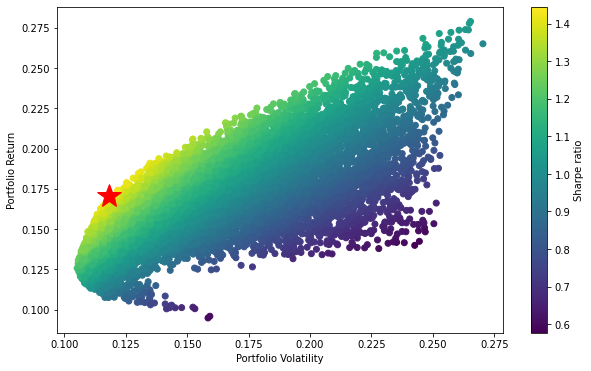

In [16]:
from src.portfolio_simulation import portfolio_simulation
port_returns, port_vols, port_weights = portfolio_simulation(returns, 10000)

In [17]:
num_assets = len(asset_list)

#Optimum weights from simulation
weights = port_weights[(port_returns/port_vols).argmax()][0]
print('Optimum weights:', list(zip(asset_list, weights)), '\n')

exp_port_return = np.sum(returns.mean()*weights)*252
print('Expected weighted return from portfolio: ' ,'{:,.2%}'.format(exp_port_return), '\n')

port_var = np.dot(weights.T, np.dot(returns.cov()*252, weights))
port_vol = np.sqrt(port_var)

print('Portfolio volatility:', '{:,.2%}'.format(port_vol))

Optimum weights: [('TLT', 0.4162758433804746), ('GLD', 0.2400798647265528), ('SPY', 0.0008594522271451283), ('QQQ', 0.34138952918889054), ('VWO', 0.0013953104769368174)] 

Expected weighted return from portfolio:  17.07% 

Portfolio volatility: 11.80%


## Portfolio VaR

In [10]:
from scipy.stats import norm

initial_investment = 1000
avg_return_investment = initial_investment * (1+exp_port_return)
std_dev_investment = initial_investment * port_vol
confidence_level = 0.05

cutoff = norm.ppf(confidence_level, avg_return_investment, std_dev_investment)

print('95% confidence of maximum loss in a year:', (initial_investment - cutoff))

95% confidence of maximum loss in a year: 32.83812703956448


## Using optimize function

In [8]:
constraints = ({'type' : 'eq', 'fun': lambda x: np.sum(x) -1})
bounds = tuple((0,1) for x in range(num_assets))
initializer = num_assets * [1./num_assets,]

print(initializer)
print(bounds)
print(constraints)

### First row is NaN (because it is a table of returns),
### and we transpose to be able to multiplicate by weights
returns_matrix = np.array(returns[1:]).T 

[0.2, 0.2, 0.2, 0.2, 0.2]
((0, 1), (0, 1), (0, 1), (0, 1), (0, 1))
{'type': 'eq', 'fun': <function <lambda> at 0x7f902a650400>}


In [9]:
import scipy.optimize as optimize
from src.portfolio_optimization import minimize_sharpe

optimal_sharpe=optimize.minimize(minimize_sharpe,
                                 initializer,
                                 args=(returns_matrix, 'not_used_string'),
                                 method = 'SLSQP',
                                 bounds = bounds,
                                 constraints = constraints)
print(optimal_sharpe)

     fun: -1.4575858553841983
     jac: array([-7.26684928e-04, -3.52725387e-04,  3.09398785e-01,  9.46402550e-04,
        5.93828470e-01])
 message: 'Optimization terminated successfully'
    nfev: 43
     nit: 7
    njev: 7
  status: 0
 success: True
       x: array([4.09392693e-01, 2.01238024e-01, 8.86877377e-17, 3.89369283e-01,
       1.19262239e-17])


In [10]:
optimal_sharpe_weights=optimal_sharpe['x'].round(4)
list(zip(asset_list,list(optimal_sharpe_weights)))

[('TLT', 0.4094), ('GLD', 0.2012), ('SPY', 0.0), ('QQQ', 0.3894), ('VWO', 0.0)]

In [11]:
from src.portfolio_stats import portfolio_stats

optimal_stats = portfolio_stats(optimal_sharpe_weights, returns_matrix)

print('Optimal Portfolio Return: ', round(optimal_stats['return']*100,4))
print('Optimal Portfolio Volatility: ', round(optimal_stats['volatility']*100,4))
print('Optimal Portfolio Sharpe Ratio: ', round(optimal_stats['sharpe'],4))

Optimal Portfolio Return:  17.8859
Optimal Portfolio Volatility:  12.2709
Optimal Portfolio Sharpe Ratio:  1.4576


### Optimizing with differential evolution (mean-variance portfolio (max sharpe ratio) and minimum-variance portfolio (min volatility))

In [12]:
from scipy.optimize import differential_evolution, NonlinearConstraint
from src.portfolio_optimization import minimize_sharpe

def constraint_weights(x):
    return x.sum()

nlc = NonlinearConstraint(constraint_weights, 0.9999, 1)

optimal_sharpe= differential_evolution(
    minimize_sharpe,
    args=(returns_matrix, 'not_used_string'),
    constraints=(nlc),  
    bounds=bounds,
    workers=-1,
    disp=True,
    maxiter=1000)

print(optimal_sharpe)

differential_evolution step 1: f(x)= inf
differential_evolution step 2: f(x)= inf
differential_evolution step 3: f(x)= inf
differential_evolution step 4: f(x)= inf
differential_evolution step 5: f(x)= inf
differential_evolution step 6: f(x)= inf
differential_evolution step 7: f(x)= inf
differential_evolution step 8: f(x)= inf
differential_evolution step 9: f(x)= inf
differential_evolution step 10: f(x)= inf
differential_evolution step 11: f(x)= inf
differential_evolution step 12: f(x)= inf
differential_evolution step 13: f(x)= inf
differential_evolution step 14: f(x)= inf
differential_evolution step 15: f(x)= inf
differential_evolution step 16: f(x)= inf
differential_evolution step 17: f(x)= inf
differential_evolution step 18: f(x)= inf
differential_evolution step 19: f(x)= inf
differential_evolution step 20: f(x)= inf
differential_evolution step 21: f(x)= inf
differential_evolution step 22: f(x)= inf
differential_evolution step 23: f(x)= inf
differential_evolution step 24: f(x)= inf
d

In [13]:
optimal_sharpe_weights=optimal_sharpe['x'].round(4)
print(list(zip(asset_list,list(optimal_sharpe_weights))))

print(optimal_sharpe_weights.sum())

[('TLT', 0.4095), ('GLD', 0.2013), ('SPY', 0.0), ('QQQ', 0.3892), ('VWO', 0.0)]
1.0


In [14]:
from src.portfolio_stats import portfolio_stats

optimal_stats = portfolio_stats(optimal_sharpe_weights, returns_matrix)

print('Optimal Portfolio Return: ', round(optimal_stats['return']*100,4))
print('Optimal Portfolio Volatility: ', round(optimal_stats['volatility']*100,4))
print('Optimal Portfolio Sharpe Ratio: ', round(optimal_stats['sharpe'],4))

Optimal Portfolio Return:  17.8822
Optimal Portfolio Volatility:  12.2684
Optimal Portfolio Sharpe Ratio:  1.4576


In [18]:
from scipy.optimize import differential_evolution, NonlinearConstraint
from src.portfolio_optimization import minimize_volatility

def constraint_weights(x):
    return x.sum()

nlc = NonlinearConstraint(constraint_weights, 0.9999, 1)

minimum_volatility = differential_evolution(
    minimize_volatility,
    args=(returns_matrix, 'not_used_string'),
    constraints=(nlc),  
    bounds=bounds,
    workers=-1,
    disp=True,
    maxiter=1000)

print(minimum_volatility)

differential_evolution step 1: f(x)= inf
differential_evolution step 2: f(x)= inf
differential_evolution step 3: f(x)= inf
differential_evolution step 4: f(x)= inf
differential_evolution step 5: f(x)= inf
differential_evolution step 6: f(x)= inf
differential_evolution step 7: f(x)= inf
differential_evolution step 8: f(x)= inf
differential_evolution step 9: f(x)= inf
differential_evolution step 10: f(x)= inf
differential_evolution step 11: f(x)= inf
differential_evolution step 12: f(x)= inf
differential_evolution step 13: f(x)= inf
differential_evolution step 14: f(x)= inf
differential_evolution step 15: f(x)= inf
differential_evolution step 16: f(x)= inf
differential_evolution step 17: f(x)= inf
differential_evolution step 18: f(x)= inf
differential_evolution step 19: f(x)= inf
differential_evolution step 20: f(x)= inf
differential_evolution step 21: f(x)= inf
differential_evolution step 22: f(x)= inf
differential_evolution step 23: f(x)= inf
differential_evolution step 24: f(x)= inf
d

In [19]:
minimum_volatility_weights=minimum_volatility['x'].round(4)
print(list(zip(asset_list,list(minimum_volatility_weights))))

print(minimum_volatility_weights.sum())

[('TLT', 0.4849), ('GLD', 0.2078), ('SPY', 0.2724), ('QQQ', 0.0), ('VWO', 0.0348)]
0.9999


In [20]:
from src.portfolio_stats import portfolio_stats

minimum_volatility_stats = portfolio_stats(minimum_volatility_weights, returns_matrix)

print('Optimal Portfolio Return: ', round(minimum_volatility_stats['return']*100,4))
print('Optimal Portfolio Volatility: ', round(minimum_volatility_stats['volatility']*100,4))
print('Optimal Portfolio Sharpe Ratio: ', round(minimum_volatility_stats['sharpe'],4))

Optimal Portfolio Return:  12.6361
Optimal Portfolio Volatility:  10.4897
Optimal Portfolio Sharpe Ratio:  1.2046
